In [2]:
!pip install MDAnalysis
!pip install nglview

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.7/108.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 101.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 91.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.9/21.9 MB 89.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 83.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 78.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.9/386.9 kB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━

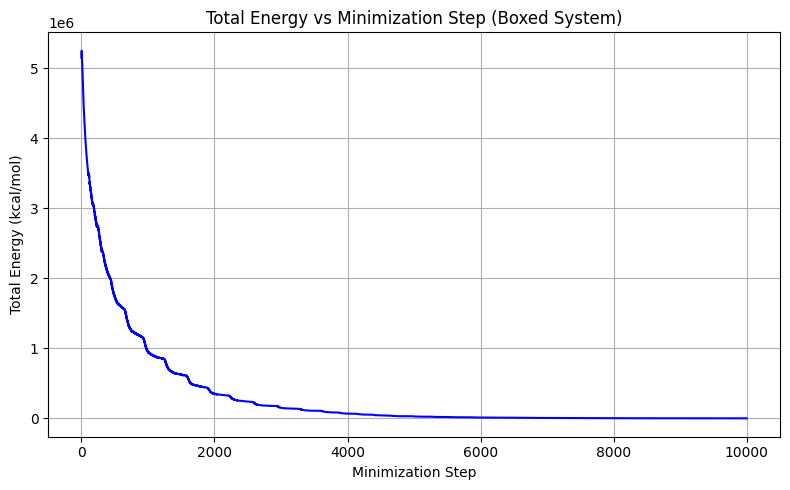

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# Load and parse the log file to extract minimization energy data
log_path = "/content/polyAB_35chains_boxed-1.log"

# We'll store parsed step and energy values
steps = []
energies = []

with open(log_path, 'r') as file:
    for line in file:
        # NAMD outputs lines like: "ENERGY:     1000   -5678.123 ..."
        if line.startswith("ENERGY:"):
            parts = re.split(r'\s+', line.strip())
            try:
                step = int(parts[1])
                total_energy = float(parts[2])
                if step <= 10000:  # Only consider the first 10,000 steps
                    steps.append(step)
                    energies.append(total_energy)
            except (IndexError, ValueError):
                continue

# Convert to DataFrame
df_min = pd.DataFrame({
    "Step": steps,
    "TotalEnergy": energies
})

# Plotting
plt.figure(figsize=(8,5))
plt.plot(df_min["Step"], df_min["TotalEnergy"], color='blue')
plt.xlabel("Minimization Step")
plt.ylabel("Total Energy (kcal/mol)")
plt.title("Total Energy vs Minimization Step (Boxed System)")
plt.grid(True)
plt.tight_layout()
plt.savefig("energy_vs_step_minimization.png")
plt.show()

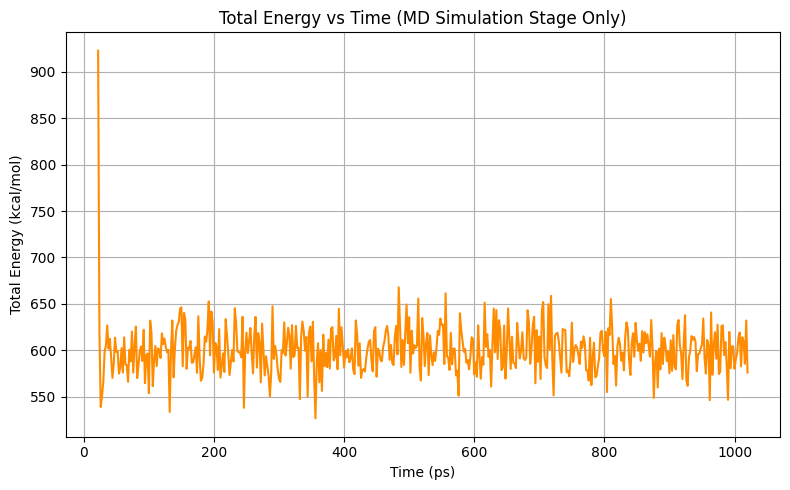

In [15]:
# Re-parse the new (updated) log file which likely contains the full MD simulation
log_path_md = "/content/polyAB_35chains_boxed-1.log"

steps_md = []
energies_md = []

with open(log_path_md, 'r') as file:
    for line in file:
        if line.startswith("ENERGY:"):
            parts = re.split(r'\s+', line.strip())
            try:
                step = int(parts[1])
                total_energy = float(parts[2])
                if step > 10000:  # MD part only
                    steps_md.append(step)
                    energies_md.append(total_energy)
            except (IndexError, ValueError):
                continue

# Convert to DataFrame
df_md = pd.DataFrame({
    "Step": steps_md,
    "TotalEnergy": energies_md
})

# Convert steps to time in ps (2 fs = 0.002 ps)
df_md["Time_ps"] = df_md["Step"] * 0.002

# Plotting
plt.figure(figsize=(8,5))
plt.plot(df_md["Time_ps"], df_md["TotalEnergy"], color='darkorange')
plt.xlabel("Time (ps)")
plt.ylabel("Total Energy (kcal/mol)")
plt.title("Total Energy vs Time (MD Simulation Stage Only)")
plt.grid(True)
plt.tight_layout()
plt.savefig("energy_vs_time_md_only_fixed.png")
plt.show()

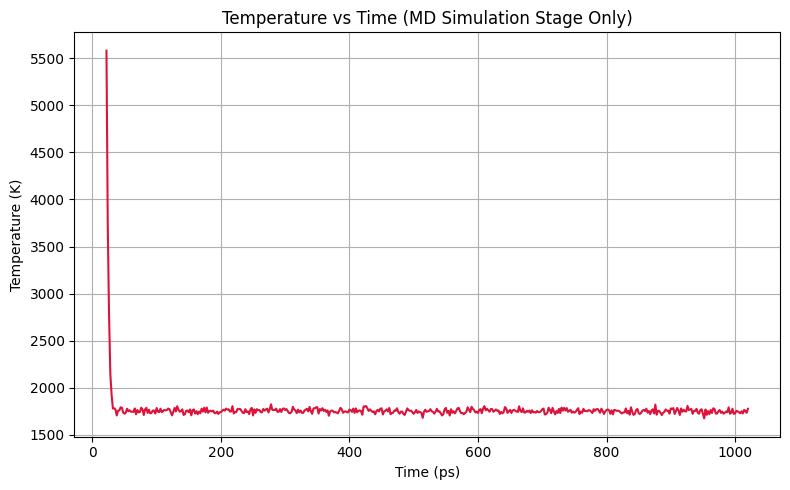

In [16]:
# Parse temperature data for MD simulation stage (step > 10000)
steps_temp = []
temps = []

with open(log_path_md, 'r') as file:
    for line in file:
        if line.startswith("ENERGY:"):
            parts = re.split(r'\s+', line.strip())
            try:
                step = int(parts[1])
                temperature = float(parts[3])  # temperature is the 3rd number after ENERGY:
                if step > 10000:
                    steps_temp.append(step)
                    temps.append(temperature)
            except (IndexError, ValueError):
                continue

# Create DataFrame for temperature
df_temp = pd.DataFrame({
    "Step": steps_temp,
    "Temperature": temps
})
df_temp["Time_ps"] = df_temp["Step"] * 0.002

# Plotting temperature vs time
plt.figure(figsize=(8,5))
plt.plot(df_temp["Time_ps"], df_temp["Temperature"], color='crimson')
plt.xlabel("Time (ps)")
plt.ylabel("Temperature (K)")
plt.title("Temperature vs Time (MD Simulation Stage Only)")
plt.grid(True)
plt.tight_layout()
plt.savefig("temperature_vs_time_md_only.png")
plt.show()

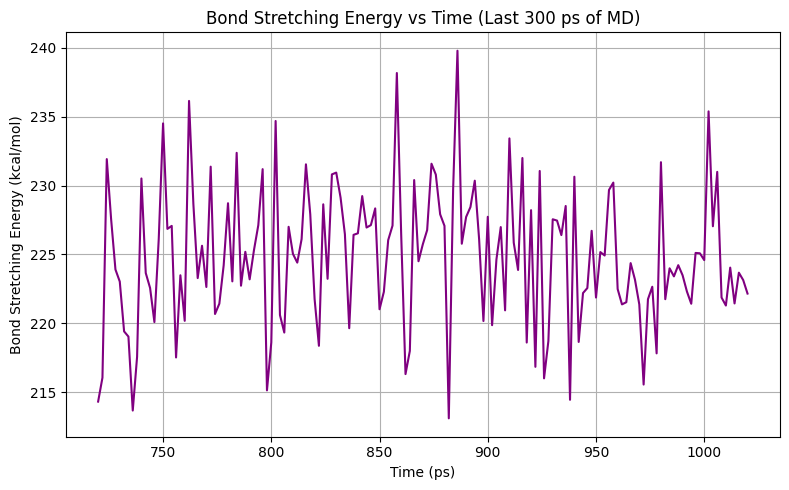

In [4]:
# Last 300 ps corresponds to time >= (max time - 300)
max_time = df_md["Time_ps"].max()
cutoff_time = max_time - 300  # e.g. if max_time is 1000 ps, last 300 ps = from 700 to 1000

# Re-parse the log to extract bond energy in last 300 ps
steps_bond = []
bond_energies = []
times_bond = []

with open(log_path_md, 'r') as file:
    for line in file:
        if line.startswith("ENERGY:"):
            parts = re.split(r'\s+', line.strip())
            try:
                step = int(parts[1])
                bond_energy = float(parts[4])  # bond energy is 4th number after ENERGY:
                time_ps = step * 0.002
                if step > 10000 and time_ps >= cutoff_time:
                    steps_bond.append(step)
                    bond_energies.append(bond_energy)
                    times_bond.append(time_ps)
            except (IndexError, ValueError):
                continue

# DataFrame for bond energy
df_bond = pd.DataFrame({
    "Step": steps_bond,
    "Time_ps": times_bond,
    "BondEnergy": bond_energies
})

# Plot
plt.figure(figsize=(8,5))
plt.plot(df_bond["Time_ps"], df_bond["BondEnergy"], color='purple')
plt.xlabel("Time (ps)")
plt.ylabel("Bond Stretching Energy (kcal/mol)")
plt.title("Bond Stretching Energy vs Time (Last 300 ps of MD)")
plt.grid(True)
plt.tight_layout()
plt.savefig("bond_energy_last_300ps.png")
plt.show()

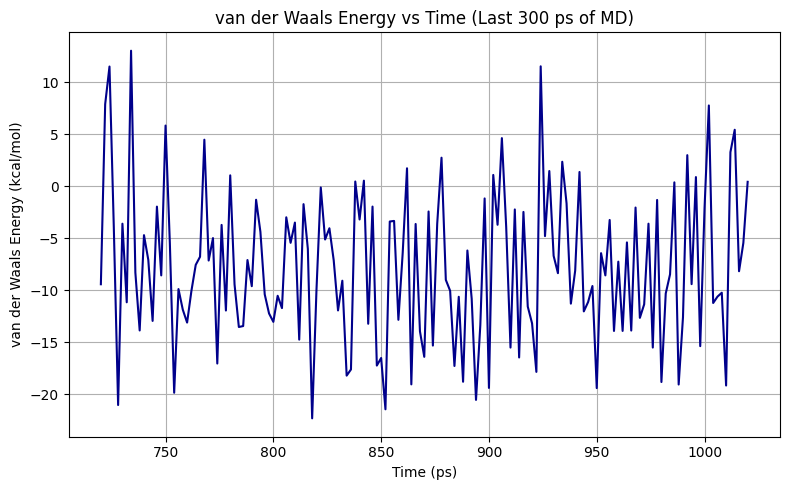

In [5]:
# Re-parse van der Waals (vdW) energy for the last 300 ps
steps_vdw = []
vdw_energies = []
times_vdw = []

with open(log_path_md, 'r') as file:
    for line in file:
        if line.startswith("ENERGY:"):
            parts = re.split(r'\s+', line.strip())
            try:
                step = int(parts[1])
                vdw_energy = float(parts[7])  # vdW energy is 7th number after ENERGY:
                time_ps = step * 0.002
                if step > 10000 and time_ps >= cutoff_time:
                    steps_vdw.append(step)
                    vdw_energies.append(vdw_energy)
                    times_vdw.append(time_ps)
            except (IndexError, ValueError):
                continue

# DataFrame
df_vdw = pd.DataFrame({
    "Step": steps_vdw,
    "Time_ps": times_vdw,
    "VdWEnergy": vdw_energies
})

# Plot
plt.figure(figsize=(8,5))
plt.plot(df_vdw["Time_ps"], df_vdw["VdWEnergy"], color='darkblue')
plt.xlabel("Time (ps)")
plt.ylabel("van der Waals Energy (kcal/mol)")
plt.title("van der Waals Energy vs Time (Last 300 ps of MD)")
plt.grid(True)
plt.tight_layout()
plt.savefig("vdw_energy_last_300ps.png")
plt.show()

/usr/local/lib/python3.11/dist-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
/usr/local/lib/python3.11/dist-packages/MDAnalysis/analysis/dihedrals.py:337: DeprecationWarning: The `angle` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.angles` instead
  warnings.warn(wmsg, DeprecationWarning)


Degree stats: -179.99949243834658 179.9999313161429


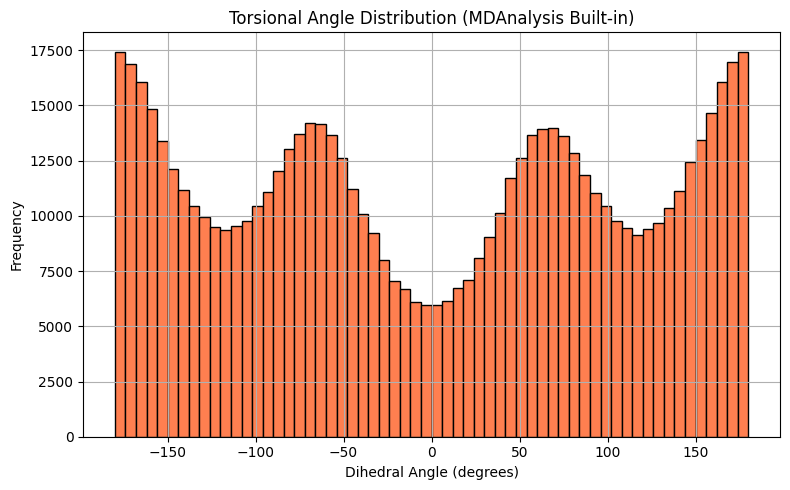

In [7]:
import MDAnalysis as mda
from MDAnalysis.analysis.dihedrals import Dihedral
import numpy as np
import matplotlib.pyplot as plt

u = mda.Universe("/content/bimbimbam_formatted_autopsf.psf", "/content/polyAB_35chains_boxed-1.dcd")
dihedral_groups = u.dihedrals

d = Dihedral(dihedral_groups).run()

angles_deg = np.array(d.angles).flatten()
print("Degree stats:", np.min(angles_deg), np.max(angles_deg))

# Plot
plt.figure(figsize=(8, 5))
plt.hist(angles_deg, bins=60, color='coral', edgecolor='black')
plt.title("Torsional Angle Distribution (MDAnalysis Built-in)")
plt.xlabel("Dihedral Angle (degrees)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

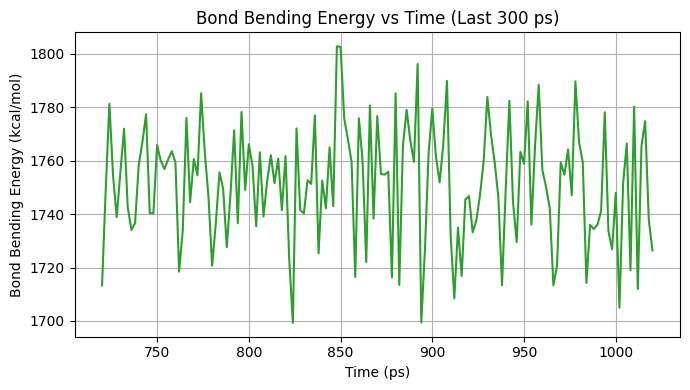

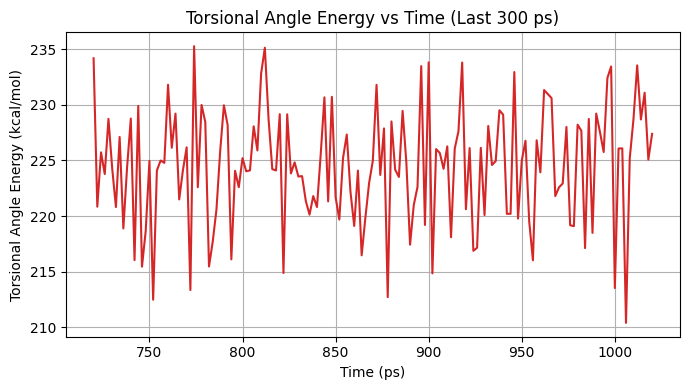

In [2]:
import re
import pandas as pd
import matplotlib.pyplot as plt

log_path = "/content/polyAB_35chains_boxed-1.log"

# storage
steps, times = [], []
bondE, angleE, dihedE = [], [], []

# constants
dt_ps = 0.002      # 2 fs → 0.002 ps
last_ps = 300

with open(log_path) as f:
    for line in f:
        if not line.startswith("ENERGY:"): continue
        parts = re.split(r"\s+", line.strip())
        try:
            step = int(parts[1])
            t = step * dt_ps
            b = float(parts[2])
            a = float(parts[3])
            d = float(parts[4])
        except:
            continue
        steps.append(step)
        times.append(t)
        bondE.append(b)
        angleE.append(a)
        dihedE.append(d)

# assemble DataFrame
df = pd.DataFrame({
    "Step": steps,
    "Time_ps": times,
    "Bond": bondE,
    "Angle": angleE,
    "Dihedral": dihedE,
})

# filter last 300 ps
t0 = df["Time_ps"].max() - last_ps
df300 = df[df["Time_ps"] >= t0]

# plotting helper
def plot_col(col, color, ylabel, fname):
    plt.figure(figsize=(7,4))
    plt.plot(df300["Time_ps"], df300[col], color=color)
    plt.title(f"{ylabel} vs Time (Last {last_ps} ps)")
    plt.xlabel("Time (ps)")
    plt.ylabel(f"{ylabel} (kcal/mol)")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(fname)
    plt.show()

# make the two plots
plot_col("Angle",    "tab:green",  "Bond Bending Energy",  "angle_last300ps.png")
plot_col("Dihedral", "tab:red",    "Torsional Angle Energy","dihed_last300ps.png")

In [6]:
import MDAnalysis as mda
from MDAnalysis.analysis.rdf import InterRDF
import matplotlib.pyplot as plt
import numpy as np

# 1) Load toplogy & trajectory
u = mda.Universe("/content/bimbimbam_formatted_autopsf.psf",
                 "/content/polyAB_35chains_boxed-1.dcd")

# 2) Select groups
group_A = u.select_atoms("name A1 A2")
group_B = u.select_atoms("name B1 B2")

# 3) Compute RDFs (15 Å, 200 bins, skip self-pairs where needed)
r_max, nbins = 15.0, 200
rdf_AA = InterRDF(group_A, group_A, range=(0., r_max),
                  nbins=nbins, pbc=True, exclude_ii=True).run()
rdf_BB = InterRDF(group_B, group_B, range=(0., r_max),
                  nbins=nbins, pbc=True, exclude_ii=True).run()
rdf_AB = InterRDF(group_A, group_B, range=(0., r_max),
                  nbins=nbins, pbc=True).run()

# 4) Helper to save one plot
def save_rdf(bins, g_of_r, label, colour, fname):
    plt.figure(figsize=(7,5))
    plt.plot(bins, g_of_r, color=colour, lw=1.3)
    plt.xlabel("r (Å)")
    plt.ylabel("g(r)")
    plt.title(f"Radial Distribution Function — {label}")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(fname, dpi=300)
    plt.close()

# 5) Save three separate PNGs (skip first bin at r ≈ 0 Å)
bins = rdf_AA.bins[1:]
save_rdf(bins, rdf_AA.rdf[1:], "A–A", "tab:blue",   "rdf_AA.png")
save_rdf(bins, rdf_BB.rdf[1:], "B–B", "tab:orange", "rdf_BB.png")
save_rdf(bins, rdf_AB.rdf[1:], "A–B", "tab:green",  "rdf_AB.png")

print("✔  Saved: rdf_AA.png, rdf_BB.png, rdf_AB.png")

✔  Saved: rdf_AA.png, rdf_BB.png, rdf_AB.png


In [11]:
import re, pandas as pd

dt_ps = 0.002

# ---- grab only 3 ENERGY lines for inspection ----
log_path = "/content/polyAB_35chains_boxed-1.log"
with open(log_path) as f:
    for i,line in enumerate(f):
        if line.startswith("ENERGY:"):
            print(f"LINE {i}: {line.strip()}")
            if i > 100:  # stop early once we have a few lines
                break

cols = {"Bond":2,"Angle":3,"Dihed":4,"VDW":7}
data = {k:[] for k in cols}; times=[]

with open(log_path) as f:
    for line in f:
        if not line.startswith("ENERGY:"): continue
        p = re.split(r"\s+", line.strip())
        times.append(int(p[1])*dt_ps)
        for name,idx in cols.items():
            data[name].append(float(p[idx]))

df = pd.DataFrame(data); df["Time_ps"]=times
cut = df.Time_ps.max() - 300
stats = df[df.Time_ps>=cut].agg(['mean','std'])
print("\nLast 300 ps stats:")
print(stats.round(2))

LINE 202: ENERGY:       0   5150247.4910    474053.7092       101.4006         0.0000              0.0000   3659427.0189         0.0000         0.0000         0.0000        9283829.6197         0.0000   9283829.6197   9283829.6197         0.0000              0.0000         0.0000     15625.0000         0.0000         0.0000

Last 300 ps stats:
        Bond    Angle   Dihed   VDW  Time_ps
mean  599.13  1751.33  224.83 -7.76   870.00
std    20.97    22.52    5.03  7.31    87.47
